In [1]:
# COLAB ONLY CELLS
try:
    import google.colab
    IN_COLAB = True
    !pip install -U gensim  # Install gensim 4
    !nvidia-smi             # Check which GPU has been chosen for us
    !rm -rf logs
    from google.colab import drive
    drive.mount('/content/drive')
    !cp -r /content/drive/MyDrive/Uni/Magistrale/NLP/Project/data/ data
except:
    IN_COLAB = False

# Question Answering Project

## Data Preprocessing

### Imports

In [2]:
%load_ext tensorboard

import os
import requests
import zipfile
from tqdm import tqdm
import time
import random
import datetime
from IPython.display import display
from functools import partial

from typing import List, Dict, Callable, Sequence, Tuple

from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import gensim
import gensim.downloader as gloader
assert int(gensim.__version__.split('.')[0]) >= 4, "Install gensim 4.x.x or above (pip install -U gensim)"

%matplotlib inline

BATCH_SIZE = 64

# Fix random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

### Dataset Analysis

We load the dataset and explore it.

In [3]:
CURRENT_PATH = os.getcwd()
ROOT_PATH = os.path.dirname(CURRENT_PATH)
TRAINING_FILE = os.path.join(ROOT_PATH, 'data', 'training_set.json')

with open(TRAINING_FILE, 'r') as f:
    questions = json.load(f)

The file is a list of articles (identified by the "title"), each divided in paragraphs (identified by the "context"), each with a list of questions ("qas"). 
Each qas has:
- "id": integer
- "question": string --> the text of the question
- "answers": the list of possible answers, with 2 informations:
    - "answer_start": integer --> the character with whichc the answer starts
    - "text": string --> the whole text of the answer 

In [4]:
print("TITLE of the article")
print(questions["data"][0]["title"], "\n")
print("TEXT of one of the article's paragraphs")
print(questions["data"][0]["paragraphs"][0]["context"], "\n")
print("TEXT of one of the paragraphs' questions")
print(questions["data"][0]["paragraphs"][0]["qas"][0]["question"], "\n")
print("ID of one of the paragraphs' questions")
print(questions["data"][0]["paragraphs"][0]["qas"][0]["id"], "\n")
print("STARTING CHARACTER NUMBER of one of the questions' answers")
print(questions["data"][0]["paragraphs"][0]["qas"][0]["answers"][0]["answer_start"], "\n")
print("TEXT of one of the questions' answers")
print(questions["data"][0]["paragraphs"][0]["qas"][0]["answers"][0]["text"], "\n")
print("VERSION of the dataset")
print(questions["version"])

TITLE of the article
University_of_Notre_Dame 

TEXT of one of the article's paragraphs
Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary. 

TEXT of one of the paragraphs' questions
To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France? 

ID of one of the paragraphs' questions
5733be284776f41900661182 

STARTING CHARACTER NUMBER of one 

The training set contains 442 articles

On average, each articles contains 42.75 paragraphs...
	with a maximum of 149 paragraphs...
	and a minimum of 5 paragraphs...
	and a standard deviation of 21.69423.

On average, each paragraph is 735.78 characters long...
	with a maximum of 3706 chars...
	and a minimum of 151 chars...
	and a standard deviation of 309.96450...
	over a total of 18896 paragraphs.

On average, each paragraph contains 4.64 questions...
	with a maximum of 25 questions...
	and a minimum of 1 questions...
	and a standard deviation of 1.68096.

On average, each question is 59.57 characters long...
	with a maximum of 25651 chars...
	and a minimum of 1 chars...
	and a standard deviation of 89.02705.

On average, each question has 1.00 answers...
	with a maximum of 1 answers...
	and a minimum of 1 answers...
	and a standard deviation of 0.00000...
	over a total of 87599 questions.

On average, each answer has 20.15 chars...
	with a maximum of 239 chars...
	and a minimum of 1

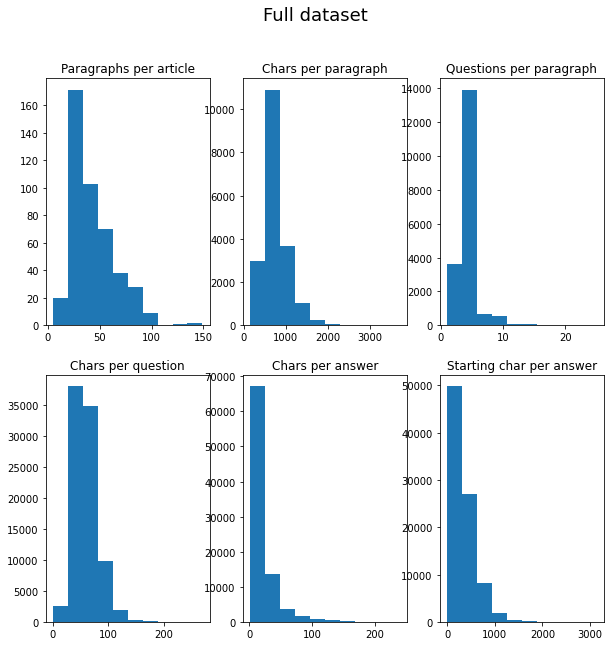

In [5]:
def get_stats(elemlist:List[float]):
    '''
    Returns useful stats of list of floats
    '''
    return  np.average(elemlist), np.max(elemlist),\
            np.min(elemlist), np.std(elemlist)

def plot_stats(elemlist:List[float], ax:plt.Axes, title:str):
    ax.hist(elemlist)
    ax.set_title(title)


def print_stats(dataset:Dict, title:str):
    # The length of the dataset is the number of articles
    print("The training set contains {} articles\n".format(len(dataset['data'])))
    # For each article in the data we extract the number of its paragraphs
    paragraphs_len = [ len(article['paragraphs']) for article in dataset['data'] ]
    # And then we print some stats on how many paragraphs per article we have
    avg_paragraphs_len, max_paragraphs_len, min_paragraphs_len, std_paragraphs_len = \
        get_stats(paragraphs_len)
    print("On average, each articles contains {:.2f} paragraphs...".format(avg_paragraphs_len))
    print("\twith a maximum of {} paragraphs...".format(max_paragraphs_len))
    print("\tand a minimum of {} paragraphs...".format(min_paragraphs_len))
    print("\tand a standard deviation of {:.5f}.\n".format(std_paragraphs_len))

    # Then we find the length of the text of the paragraphs
    contexts_len = [ len(paragraph['context']) for article in dataset['data'] 
                                            for paragraph in article['paragraphs'] ]
    # And print some stats
    avg_context_len, max_context_len, min_context_len, std_context_len = \
        get_stats(contexts_len)
    print("On average, each paragraph is {:.2f} characters long...".format(avg_context_len))
    print("\twith a maximum of {} chars...".format(max_context_len))
    print("\tand a minimum of {} chars...".format(min_context_len))
    print("\tand a standard deviation of {:.5f}...".format(std_context_len))
    # We also add the total number of paragraphs
    print("\tover a total of {} paragraphs.\n".format(len(contexts_len)))

    # Same thing as before: how many questions for each context
    questions_len = [ len(paragraph['qas']) for article in dataset['data'] 
                                            for paragraph in article['paragraphs'] ]
    # And print some stats
    avg_questions_len, max_questions_len, min_questions_len, std_questions_len = \
        get_stats(questions_len)
    print("On average, each paragraph contains {:.2f} questions...".format(avg_questions_len))
    print("\twith a maximum of {} questions...".format(max_questions_len))
    print("\tand a minimum of {} questions...".format(min_questions_len))
    print("\tand a standard deviation of {:.5f}.\n".format(std_questions_len))

    # Same thing as before: how many questions for each context
    questions_text_len = [ len(question['question']) for article in dataset['data'] 
                                            for paragraph in article['paragraphs']
                                            for question in paragraph["qas"] ]
    # And print some stats
    avg_questions_text_len, max_questions_text_len, min_questions_text_len, std_questions_text_len = \
        get_stats(questions_text_len)
    print("On average, each question is {:.2f} characters long...".format(avg_questions_text_len))
    print("\twith a maximum of {} chars...".format(max_questions_text_len))
    print("\tand a minimum of {} chars...".format(min_questions_text_len))
    print("\tand a standard deviation of {:.5f}.\n".format(std_questions_text_len))

    # How many answers for each question
    answers_len = [ len(question['answers']) for article in dataset['data'] 
                                            for paragraph in article['paragraphs']
                                            for question in paragraph['qas'] ]
    # Print some stats
    avg_answers_len, max_answers_len, min_answers_len, std_answers_len = \
        get_stats(answers_len)
    print("On average, each question has {:.2f} answers...".format(avg_answers_len))
    print("\twith a maximum of {} answers...".format(max_answers_len))
    print("\tand a minimum of {} answers...".format(min_answers_len))
    print("\tand a standard deviation of {:.5f}...".format(std_answers_len))
    # Also adding the total number of questions
    print("\tover a total of {} questions.\n".format(len(answers_len)))

    # How many chars for THE answer to each question (since there is ONLY one answer for each question, always)
    answers_text_len = [ len(question['answers'][0]['text']) for article in dataset['data'] 
                                            for paragraph in article['paragraphs']
                                            for question in paragraph['qas'] ]
    # Print some stats
    avg_answers_text_len, max_answers_text_len, min_answers_text_len, std_answers_text_len = \
        get_stats(answers_text_len)
    print("On average, each answer has {:.2f} chars...".format(avg_answers_text_len))
    print("\twith a maximum of {} chars...".format(max_answers_text_len))
    print("\tand a minimum of {} chars...".format(min_answers_text_len))
    print("\tand a standard deviation of {:.5f}...".format(std_answers_text_len))

    answers_start = [ question['answers'][0]['answer_start'] for article in dataset['data'] 
                                            for paragraph in article['paragraphs']
                                            for question in paragraph['qas'] ]
    # Print some stats
    avg_answers_start, max_answers_start, min_answers_start, std_answers_start = \
        get_stats(answers_start)
    print("On average, each answer starts at position {:.2f} ...".format(avg_answers_start))
    print("\twith a maximum of {} ...".format(max_answers_start))
    print("\tand a minimum of {} ...".format(min_answers_start))
    print("\tand a standard deviation of {:.5f}...".format(std_answers_start))

    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3, figsize=(10,10))
    fig.suptitle(title, fontsize=18)
    plot_stats(paragraphs_len, ax1, 'Paragraphs per article')
    plot_stats(contexts_len, ax2, 'Chars per paragraph')
    plot_stats(questions_len, ax3, 'Questions per paragraph')
    plot_stats(np.sort(questions_text_len)[:-1], ax4, 'Chars per question') # there is one CLEAR outlier with 25k chars, while the mean is 60 and std is 90. We remove it from the plot
    # TODO: maybe look into the outlier
    # plot_stats(answers_len, ax5, 'Answers per question') # Removed because it's just 1 always
    plot_stats(answers_text_len, ax5, 'Chars per answer')
    plot_stats(answers_start, ax6, 'Starting char per answer')

print_stats(questions, 'Full dataset')

We observe that on the training set there is only one answer for each question. On the tests set there could be multiple answers, but this should only be important when evaluating the model with the evaluation script.

### Dataset splitting

We can split the dataset into train and validation based on the articles' titles, so that questions related to one article are all either in the training or in the validation set.

We use a 75-25 train-val split and check that the two splits approximately have the same properties.

In [6]:
TRAIN_SPLIT_ELEM = int(len(questions['data']) / 100 * 75)
print("Using {} articles for validation and {} for training".format(
    len(questions['data']) - TRAIN_SPLIT_ELEM, TRAIN_SPLIT_ELEM)
)

data = random.sample(questions['data'], len(questions['data'])) # reshuffle the samples

Using 111 articles for validation and 331 for training


In [7]:
train_dataset = {'data': data[:TRAIN_SPLIT_ELEM]} # recreate the original dataset structure lost by shuffling through the dictionary
val_dataset = {'data': data[TRAIN_SPLIT_ELEM:]}

# we also create a small training set to test the model while building it, just to speed up
SMALL_TRAIN_ELEM = 32
small_data = random.sample(train_dataset["data"], SMALL_TRAIN_ELEM)
small_train_dataset = {'data': small_data}

The training set contains 331 articles

On average, each articles contains 42.22 paragraphs...
	with a maximum of 149 paragraphs...
	and a minimum of 5 paragraphs...
	and a standard deviation of 21.71547.

On average, each paragraph is 741.17 characters long...
	with a maximum of 3706 chars...
	and a minimum of 151 chars...
	and a standard deviation of 308.37702...
	over a total of 13975 paragraphs.

On average, each paragraph contains 4.66 questions...
	with a maximum of 25 questions...
	and a minimum of 1 questions...
	and a standard deviation of 1.74980.

On average, each question is 59.95 characters long...
	with a maximum of 25651 chars...
	and a minimum of 1 chars...
	and a standard deviation of 102.59986.

On average, each question has 1.00 answers...
	with a maximum of 1 answers...
	and a minimum of 1 answers...
	and a standard deviation of 0.00000...
	over a total of 65064 questions.

On average, each answer has 19.53 chars...
	with a maximum of 239 chars...
	and a minimum of 

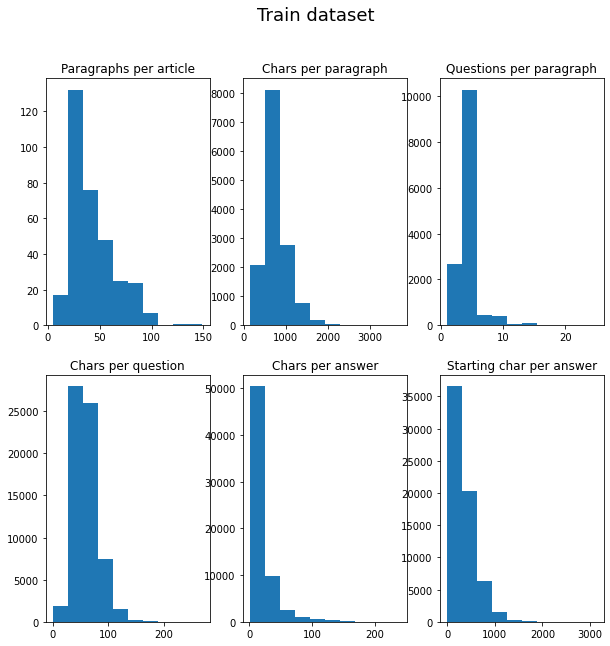

In [8]:
print_stats(train_dataset, 'Train dataset')

The training set contains 111 articles

On average, each articles contains 44.33 paragraphs...
	with a maximum of 148 paragraphs...
	and a minimum of 5 paragraphs...
	and a standard deviation of 21.55334.

On average, each paragraph is 720.47 characters long...
	with a maximum of 3355 chars...
	and a minimum of 152 chars...
	and a standard deviation of 313.92446...
	over a total of 4921 paragraphs.

On average, each paragraph contains 4.58 questions...
	with a maximum of 18 questions...
	and a minimum of 1 questions...
	and a standard deviation of 1.46650.

On average, each question is 58.49 characters long...
	with a maximum of 256 chars...
	and a minimum of 1 chars...
	and a standard deviation of 20.36586.

On average, each question has 1.00 answers...
	with a maximum of 1 answers...
	and a minimum of 1 answers...
	and a standard deviation of 0.00000...
	over a total of 22535 questions.

On average, each answer has 21.93 chars...
	with a maximum of 161 chars...
	and a minimum of 1 ch

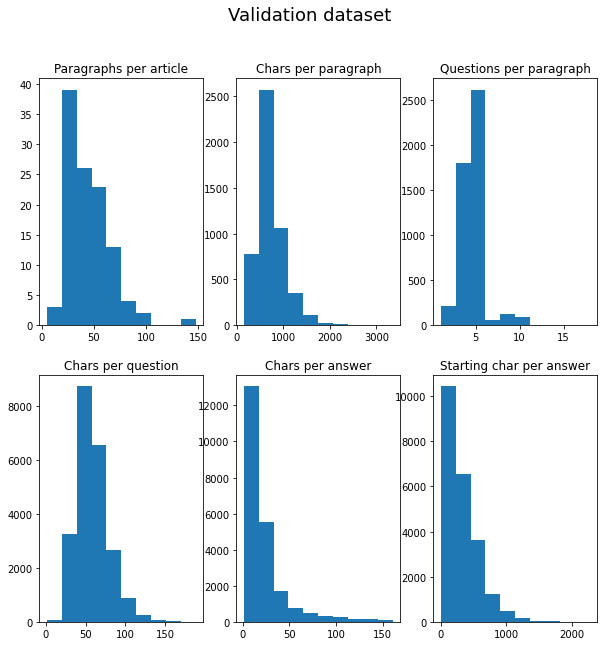

In [9]:
print_stats(val_dataset, 'Validation dataset')

The splitting was quite successful and both dataset splits have similar data distributions.

TODO: PROBLEM --> BERT only accepts fixed size length sentences up to 512 characters long!

## Dataset Exploration

Firstly, the titles of our articles will not be processed because they won't be used to predict possible answers
So let's directly look at some context, that is, some paragraphs of our articles

In [10]:
article = random.sample(train_dataset["data"], 1)[0]
paragraph = random.sample(article["paragraphs"], 1)[0]
context = paragraph["context"]
print(context)

It is often said that Russia was militarily weak, technologically backward, and administratively incompetent. Despite its grand ambitions toward the south, it had not built its railroad network in that direction, and communications were poor. The bureaucracy was riddled with graft, corruption and inefficiency and was unprepared for war. Its navy was weak and technologically backward; its army, although very large, was good only for parades, suffered from colonels who pocketed their men's pay, poor morale, and was out of touch with the latest technology developed by Britain and France. By the war's end, everyone realized the profound weaknesses of the Russian military, and the Russian leadership was determined to reform it.


By repeating the execution of the above cell some number of times, we can see the in general contexts are well defined and without evident formatting problems. This means that we should be able to feed them directly into our tokenizer

Then let's have a look at our questions

In [11]:
article = random.sample(train_dataset["data"], 1)[0]
paragraph = random.sample(article["paragraphs"], 1)[0]
question_and_answer = random.sample(paragraph["qas"], 1)[0]
question = question_and_answer["question"]
print(question)

When did ITU-R start trying to work towards setting a single international HDTV standard?


By looking at the questions, we can see that also here there are no evident formatting problems. Moreover, we can see that all the questions focus around dates and/or Named Entities. This means that we will NOT be able to discard "low frequency words" from our tokenization step, because they are the key focus of our task

And finally the answers

In [12]:
article = random.sample(train_dataset["data"], 1)[0]
paragraph = random.sample(article["paragraphs"], 1)[0]
question_and_answer = random.sample(paragraph["qas"], 1)[0]
answer_struct = random.sample(question_and_answer["answers"], 1)[0]
answer = answer_struct["text"]
print(answer)

Ding Huan


Also in this case, no problems with formatting (also because they are pieces of "contexts")

### Preprocessing and initialization of pretrained BERT

In [13]:
from transformers import DistilBertTokenizerFast, TFDistilBertModel
# we are using a tokenizer that derives from a "normal" (and not "large") BERT model
# moreover, it ignores casing --> uncased
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-cased') # TODO: cased or uncased?

Since BERT is pretrained with sentence completion, it ALWAYS expects [CLS] and [SEP] as special tokens:
- [CLS] at the beginning of the sentence
- [SEP] at the beginning of the second sentence and, if there is only one sentence because we are doing another task, at the end of the first and only sentence

For example, let's use the answer above and see how it tokenizes it:

In [14]:
answer_final = "[CLS]" + answer + "[SEP]"
tokenized_answer = tokenizer.tokenize(answer_final)
print(answer)
print(tokenized_answer)

Ding Huan
['[CLS]', 'Din', '##g', 'Hu', '##an', '[SEP]']


For example:

William Herschel --> ['[CLS]', 'william', 'hers', '##chel', '[SEP]']

'##chel' means that Herschel was an OOV for the original vocab of BERT, so it has been divided into subwords to still be able to give significant embeddings to the word

In [15]:
tokenized_text = tokenizer.tokenize(answer_final)
# now convert the tokens to ids of the BERT vocab
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
# and add a segment_id (BERT was trained with two sentences, sentence 0 and sentence 1)
segments_ids = [1] * len(tokenized_text)

tokenizer.encode() will take care of all of these steps for us

In [16]:
lengths = []

for article in train_dataset["data"]:
    for paragraph in article["paragraphs"]:
        # Tokenize and add special tokens to all our paragraphs (the longer parts of the sentences that we need to encode)
        input_ids = tokenizer.encode(paragraph["context"], add_special_tokens=True)
        # Save the length of the tokenized sentence
        lengths.append(len(input_ids))
MAX_LEN = max(lengths)
print(MAX_LEN)

Token indices sequence length is longer than the specified maximum sequence length for this model (553 > 512). Running this sequence through the model will result in indexing errors


867


In [17]:
exceeding_sentences = (np.asarray(lengths) > 512).sum()
print("Total exceeding sentences: ", exceeding_sentences)
print("Percentage out of total number of paragraphs ({}): {:.5f}%".format(len(lengths), exceeding_sentences/len(lengths)))

Total exceeding sentences:  20
Percentage out of total number of paragraphs (13975): 0.00143%


The longest sentence has more than 512 tokens. Since BERT only accepts up to 512 tokens, we need to decide iw we want to truncate the 16 longest sentences or maybe split them? TODO

Moreover, we will feed BERT with paragraph + question, so the two combined should be < than 512 tokens combined

In [18]:
from tqdm import tqdm
lengths_pairs = []
for article in tqdm(train_dataset["data"]):
    for paragraph in article["paragraphs"]:
        for question_and_answer in paragraph["qas"]:
            # For question answering with BERT we need to encode both question and context, and this is the way in which HuggingFace's BertTokenizer does it
            encoded_inputs = tokenizer(
                question_and_answer["question"], 
                paragraph["context"],
                return_attention_mask=False, 
                return_token_type_ids=False)
            # it returns both the token ids, the type (sentence 0 or sentence 1) and the mask (if it's real or padding) --> for length measuring they're not needed
            lengths_pairs.append(len(encoded_inputs["input_ids"]))

MAX_LEN_PAIRS = max(lengths_pairs)
exceeding_pairs = (np.asarray(lengths_pairs) > 512).sum()
print("Max length of the pairs: ", MAX_LEN_PAIRS)
print("Total exceeding pairs: ", exceeding_pairs)
print("Percentage out of total number of pairs ({}): {:.5f}%".format(len(lengths_pairs), exceeding_pairs/len(lengths_pairs)))


100%|██████████| 331/331 [00:30<00:00, 10.94it/s]

Max length of the pairs:  882
Total exceeding pairs:  110
Percentage out of total number of pairs (65064): 0.00169%


We can see that only 95 pairs, a very small percentage (0.00146%) actually exceeds 512 tokens (comprehensive of [CLS] and [SEP] special tokens)

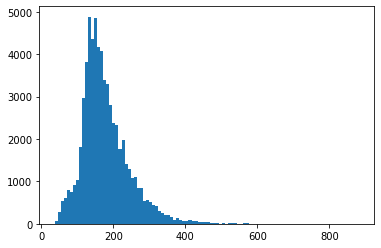

In [19]:
plt.hist(lengths_pairs, bins=100)
plt.show()

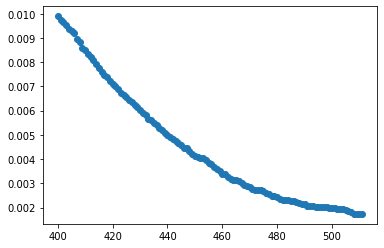

In [20]:
counts = []
low_bound = 400
for i in range(low_bound, 512):
     counts.append((np.asarray(lengths_pairs) > i).sum()/len(lengths_pairs))
plt.scatter(list(range(low_bound, 512)), counts)
plt.show()

The above distribution suggests us that we could greatly reduce the dimension of the model by reducing the size of the input, without losing too many pairs due to truncation
If we could find an effective way of truncating sentences, this could speed up the training of the model

For example: by reducing input size from 512 to 400 (~22% less) we only lose ~0.006% more pairs

Now we do the same for the answers

In [21]:
from tqdm import tqdm
lengths_answers = []
for article in tqdm(train_dataset["data"]):
    for paragraph in article["paragraphs"]:
        for question_and_answer in paragraph["qas"]:
            # For question answering with BERT we need to encode both question and context, and this is the way in which HuggingFace's BertTokenizer does it
            encoded_answers = tokenizer(
                question_and_answer["answers"][0]["text"],
                return_attention_mask=False, 
                return_token_type_ids=False)
            # it returns both the token ids, the type (sentence 0 or sentence 1) and the mask (if it's real or padding) --> for length measuring they're not needed
            lengths_answers.append(len(encoded_answers["input_ids"]))

MAX_LEN_ANSWERS = max(lengths_answers)
print("Max length of the answers: ", MAX_LEN_ANSWERS)

100%|██████████| 331/331 [00:02<00:00, 132.45it/s]

Max length of the answers:  69


In [49]:
def find_start_end_token_one_hot_encoded(starting_char: int, answer_len: int, offsets: List[Tuple[int]]) -> int:
    result = np.zeros((len(offsets), 2))
    for i in range(1, len(offsets)): # we skip the first token, [CLS], that has (0,0) as a tuple
        # we cycle through all the tokens of the quesiton, until we find (0,0)
        if offsets[i] == (0,0): # the [SEP] special char --> this indicates the beginning of the context
            for j in range(1, len(offsets)-i-1): # we skip the first and the last tokens, both special tokens
                # if the starting char is in the interval, the index (j) of its position inside the context, plus the length of the question (i) is the right index
                if (starting_char >= offsets[i+j][0]) and (starting_char <= offsets[i+j][1]):
                    result[i+j][0] += 1
                # if the ending char (starting + length -1) is in the interval, same as above
                if (starting_char + answer_len - 1 >= offsets[i+j][0]) and (starting_char + answer_len - 1 <= offsets[i+j][1]):
                    result[i+j][1] += 1
            return result

# TODO: fix max length
MAX_LEN_PAIRS = 512
train_features = []
train_labels = []
from tqdm import tqdm

#####################################################################
 ######## TODO: CHANGE LINE BELOW WITH "train_dataset" #############
#####################################################################

for article in tqdm(small_train_dataset["data"]):
    for paragraph in article["paragraphs"]:
        for question_and_answer in paragraph["qas"]:
            ### QUESTION AND CONTEXT TOKENIZATION ###
            # For question answering with BERT we need to encode both question and context, and this is the way in which HuggingFace's BertTokenizer does it
            encoded_inputs = tokenizer(
                question_and_answer["question"],    # first we pass the question
                paragraph["context"],               # then the context
                max_length = MAX_LEN_PAIRS,         # we want to pad and truncate to this length
                truncation = True,
                padding = 'max_length',             # if "True" it would pad to the longest sentence in the batch (in this case only 1 sentence, so no padding at all)
                return_token_type_ids = True,       # return if the token is from sentence 0 or sentence 1 
                return_attention_mask = True,       # return if it's a pad token or not
                return_offsets_mapping = True       # really important --> returns each token's first and last char position in the original sentence 
            )

            ### MAPPING OF THE START OF THE ANSWER BETWEEN CHARS AND TOKENS ###
            # we want to pass from the starting position in chars to the starting position in tokens
            label = find_start_end_token_one_hot_encoded(
                # we pass as starting char the one from the database
                starting_char = question_and_answer["answers"][0]["answer_start"],
                # also the length of the answer in chars
                answer_len = len(question_and_answer["answers"][0]["text"]),
                # and also the inputs offset mapping just recieved from the tokenizer
                offsets = encoded_inputs["offset_mapping"]
            )
            
            encoded_inputs.pop("offset_mapping", None) # removes the offset mapping, not useful anymore ("None" is used because otherwise KeyError could be raised if the key wasn't present)
            train_features.append(encoded_inputs)
            train_labels.append(label)
            
            # DO NOT KNOW IF IT IS NEEDED
            '''
            ### ANSWER TOKENIZATION ###
            # use the same tokenizer also to tokenize the answers
            encoded_answer = tokenizer(
                question_and_answer["answers"][0]["text"],  # here we only need to pass the answer
                max_length=MAX_LEN_ANSWERS,
                truncation = True,
                padding = 'max_length',
                add_special_tokens = False,                 # the answer will only be used for the loss, not as input to the model, it does not need special tokens [CLS] and [SEP]
                return_token_type_ids = False,              # only one sentence
                return_attention_mask = True)               # still interested in padding tokens
            
            # we add to the dictionary of the pair question-context the token ids of the answer and its mask
            encoded_inputs["answer_ids"] = encoded_answer["input_ids"]
            encoded_inputs["answer_mask"] = encoded_answer["attention_mask"]
            '''

            

100%|██████████| 32/32 [00:04<00:00,  6.82it/s]


Now we have a structure of question - context pairs + answers, and we can create a dataset

In [70]:
# directly create the dataset from the list of dictionaries
train_ds = tf.data.Dataset.from_tensor_slices((
    pd.DataFrame.from_dict(train_features).to_dict(orient="list"),  # dataframe for features 
    train_labels                                                    # simple matrix
    ))



In [71]:
for sample in train_ds.take(1):
    print(sample[0].keys()) # dict keys from the input to the transformer
    print(sample[1])        # matrix: first column contains beginning and second contains end of answer

dict_keys(['attention_mask', 'input_ids', 'token_type_ids'])
tf.Tensor(
[[0. 0.]
 [0. 0.]
 [0. 0.]
 ...
 [0. 0.]
 [0. 0.]
 [0. 0.]], shape=(512, 2), dtype=float64)


So now our data structure is a dataset:
- features:
    - input_ids: List[int] --> token ids of question + context
    - token_type_ids: List[int] --> specifies if the token is from sentence 0 or sentence 1
    - attention_mask: List[int] --> specifies if it's padding or not
- labels:
    - answer_start/end:  specifies the position of the initial and final answer's token inside the question + context array of tokens
<!-- - offset_mapping: List[Tuple[int]] start and end char of each token: for pairs of sentences the Tuple (0, 0) signifies both the [CLS] and the [SEP] tokens, and can be exploited to see if we are in the first or second sentence -->


In [72]:
# OSS: remember to call fit with this structure {"input_ids": train_df["input_ids"], ...}
# Load the model pretrained on the masked input + sentence completion task
transformer_model = TFDistilBertModel.from_pretrained("distilbert-base-cased", output_hidden_states = True) # add here config for the model, ex. also attention outputs

2022-01-08 02:07:47.190268: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 89075712 exceeds 10% of free system memory.
Some layers from the model checkpoint at distilbert-base-cased were not used when initializing TFDistilBertModel: ['vocab_transform', 'activation_13', 'vocab_projector', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already 

In [73]:
for sample in train_ds.take(1): # try if everything is working
    SHAPE_INPUT_IDS = tf.shape(sample[0]["input_ids"])[0].numpy()
    SHAPE_ATTENTION_MASK = tf.shape(sample[0]["attention_mask"])[0].numpy()
    outputs = transformer_model(
        {
            "input_ids": sample[0]["input_ids"],
            "attention_mask": sample[0]["attention_mask"], 
            "token_type_ids": sample[0]["token_type_ids"]
        },
        output_hidden_states = True,
        output_attentions = True
    )
    print("Shape of the last hidden state: ", tf.shape(outputs.last_hidden_state)) # Sequence of hidden-states at the output of the last layer of the model
    print("Shape of the other hidden states: ", tf.shape(outputs.hidden_states)) # Hidden-states of the model at the output of each layer plus the initial embedding outputs
    print("Shape of the attention weights: ", tf.shape(outputs.attentions)) # Attentions weights after the attention softmax, used to compute the weighted average in the self-attention heads

Shape of the last hidden state:  tf.Tensor([  1 512 768], shape=(3,), dtype=int32)
Shape of the other hidden states:  tf.Tensor([  7   1 512 768], shape=(4,), dtype=int32)
Shape of the attention weights:  tf.Tensor([  6   1  12 512 512], shape=(5,), dtype=int32)


Searching through HuggingFace's github, we can find DistilBert's model configurations: 
https://github.com/huggingface/transformers/blob/master/src/transformers/models/distilbert/configuration_distilbert.py 

The most important parts for us are:
- vocab_size = 30522
- max_position_embeddings = 512
- n_layers = 6
- n_heads = 12
- dim = 768
- hidden_dim = 4*768

Here is the code for the model instead:
https://github.com/huggingface/transformers/blob/master/src/transformers/models/distilbert/modeling_tf_distilbert.py

In [74]:
print(SHAPE_INPUT_IDS)
print(SHAPE_ATTENTION_MASK)

512
512


In [75]:
input_ids = tf.keras.Input(shape=(SHAPE_INPUT_IDS, ), dtype='int32')
attention_mask = tf.keras.Input(shape=(SHAPE_ATTENTION_MASK, ), dtype='int32')
token_type_ids = tf.keras.Input(shape=(SHAPE_ATTENTION_MASK, ), dtype='int32')
culo = tf.keras.Input(shape=(SHAPE_ATTENTION_MASK, ), dtype='int32')

transformer = transformer_model(
    {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "token_type_ids": token_type_ids
    }
)

# TODO: chose which layers
hidden_states = transformer.hidden_states
chosen_states_idx = [3, 4, 5, 6]

# TODO: chose merging method
chosen_hidden_states = layers.concatenate(
    tuple([hidden_states[i] for i in chosen_states_idx])
)

output = layers.Bidirectional(layers.LSTM(64, return_sequences = True, activation = "relu"))(chosen_hidden_states)
output = layers.Dense(2, activation = "softmax")(output) # 2 because we need both 

model = tf.keras.models.Model(inputs={
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "token_type_ids": token_type_ids
    },
    outputs = output)


In [76]:
# import tensorflow.keras.backend as kb
# def custom_loss(y_actual,y_pred):
#     '''
#     Simple categorical crossentropy on two different dimensions
#     y_actual: tensor of 2 ints
#     y_pred:
#     '''
#     custom_loss=kb.square(y_actual-y_pred)
#     return custom_loss

model.compile(tf.keras.optimizers.Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])


In [77]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 512)]        0           []                               
                                                                                                  
 input_17 (InputLayer)          [(None, 512)]        0           []                               
                                                                                                  
 input_19 (InputLayer)          [(None, 512)]        0           []                               
                                                                                                  
 tf_distil_bert_model_4 (TFDist  TFBaseModelOutput(l  65190912   ['input_18[0][0]',               
 ilBertModel)                   ast_hidden_state=(N               'input_17[0][0]',         

In [78]:
train_ds = train_ds.batch(2)

In [79]:
model.fit(train_ds, epochs=1)

2022-01-08 02:08:07.722094: W tensorflow/core/common_runtime/bfc_allocator.cc:462] Allocator (GPU_0_bfc) ran out of memory trying to allocate 24.00MiB (rounded to 25165824)requested by op model_4/tf_distil_bert_model_4/distilbert/transformer/layer_._4/attention/Softmax
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-01-08 02:08:07.722169: I tensorflow/core/common_runtime/bfc_allocator.cc:1010] BFCAllocator dump for GPU_0_bfc
2022-01-08 02:08:07.722185: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (256): 	Total Chunks: 164, Chunks in use: 161. 41.0KiB allocated for chunks. 40.2KiB in use in bin. 753B client-requested in use in bin.
2022-01-08 02:08:07.722194: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (512): 	Total Chunks: 1, Chunks in use: 1. 512B allocated for chunks. 512B in use in bin. 484B 

ResourceExhaustedError:  OOM when allocating tensor with shape[2,12,512,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model_4/tf_distil_bert_model_4/distilbert/transformer/layer_._4/attention/Softmax
 (defined at /home/marcello/github/NLP/Assignements/QuestionAnswering/env/lib/python3.8/site-packages/transformers/models/distilbert/modeling_tf_distilbert.py:194)
]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_74178]

Errors may have originated from an input operation.
Input Source operations connected to node model_4/tf_distil_bert_model_4/distilbert/transformer/layer_._4/attention/Softmax:
In[0] model_4/tf_distil_bert_model_4/distilbert/transformer/layer_._4/attention/sub_1 (defined at /home/marcello/github/NLP/Assignements/QuestionAnswering/env/lib/python3.8/site-packages/transformers/models/distilbert/modeling_tf_distilbert.py:193)

Operation defined at: (most recent call last)
>>>   File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "/home/marcello/github/NLP/Assignements/QuestionAnswering/env/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "/home/marcello/github/NLP/Assignements/QuestionAnswering/env/lib/python3.8/site-packages/traitlets/config/application.py", line 846, in launch_instance
>>>     app.start()
>>> 
>>>   File "/home/marcello/github/NLP/Assignements/QuestionAnswering/env/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 677, in start
>>>     self.io_loop.start()
>>> 
>>>   File "/home/marcello/github/NLP/Assignements/QuestionAnswering/env/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
>>>     self._run_once()
>>> 
>>>   File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
>>>     handle._run()
>>> 
>>>   File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "/home/marcello/github/NLP/Assignements/QuestionAnswering/env/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 457, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "/home/marcello/github/NLP/Assignements/QuestionAnswering/env/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 446, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "/home/marcello/github/NLP/Assignements/QuestionAnswering/env/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 353, in dispatch_shell
>>>     await result
>>> 
>>>   File "/home/marcello/github/NLP/Assignements/QuestionAnswering/env/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 648, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "/home/marcello/github/NLP/Assignements/QuestionAnswering/env/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 353, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "/home/marcello/github/NLP/Assignements/QuestionAnswering/env/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 532, in run_cell
>>>     return super().run_cell(*args, **kwargs)
>>> 
>>>   File "/home/marcello/github/NLP/Assignements/QuestionAnswering/env/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2914, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "/home/marcello/github/NLP/Assignements/QuestionAnswering/env/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2960, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "/home/marcello/github/NLP/Assignements/QuestionAnswering/env/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "/home/marcello/github/NLP/Assignements/QuestionAnswering/env/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3185, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "/home/marcello/github/NLP/Assignements/QuestionAnswering/env/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3377, in run_ast_nodes
>>>     if (await self.run_code(code, result,  async_=asy)):
>>> 
>>>   File "/home/marcello/github/NLP/Assignements/QuestionAnswering/env/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3457, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "/tmp/ipykernel_704156/3638608774.py", line 1, in <module>
>>>     model.fit(train_ds, epochs=1)
>>> 
>>>   File "/home/marcello/github/NLP/Assignements/QuestionAnswering/env/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/marcello/github/NLP/Assignements/QuestionAnswering/env/lib/python3.8/site-packages/keras/engine/training.py", line 1216, in fit
>>>     tmp_logs = self.train_function(iterator)
>>> 
>>>   File "/home/marcello/github/NLP/Assignements/QuestionAnswering/env/lib/python3.8/site-packages/keras/engine/training.py", line 878, in train_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "/home/marcello/github/NLP/Assignements/QuestionAnswering/env/lib/python3.8/site-packages/keras/engine/training.py", line 867, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "/home/marcello/github/NLP/Assignements/QuestionAnswering/env/lib/python3.8/site-packages/keras/engine/training.py", line 860, in run_step
>>>     outputs = model.train_step(data)
>>> 
>>>   File "/home/marcello/github/NLP/Assignements/QuestionAnswering/env/lib/python3.8/site-packages/keras/engine/training.py", line 808, in train_step
>>>     y_pred = self(x, training=True)
>>> 
>>>   File "/home/marcello/github/NLP/Assignements/QuestionAnswering/env/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/marcello/github/NLP/Assignements/QuestionAnswering/env/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/home/marcello/github/NLP/Assignements/QuestionAnswering/env/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/marcello/github/NLP/Assignements/QuestionAnswering/env/lib/python3.8/site-packages/keras/engine/functional.py", line 451, in call
>>>     return self._run_internal_graph(
>>> 
>>>   File "/home/marcello/github/NLP/Assignements/QuestionAnswering/env/lib/python3.8/site-packages/keras/engine/functional.py", line 589, in _run_internal_graph
>>>     outputs = node.layer(*args, **kwargs)
>>> 
>>>   File "/home/marcello/github/NLP/Assignements/QuestionAnswering/env/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/marcello/github/NLP/Assignements/QuestionAnswering/env/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/home/marcello/github/NLP/Assignements/QuestionAnswering/env/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/marcello/github/NLP/Assignements/QuestionAnswering/env/lib/python3.8/site-packages/transformers/models/distilbert/modeling_tf_distilbert.py", line 575, in call
>>>     outputs = self.distilbert(
>>> 
>>>   File "/home/marcello/github/NLP/Assignements/QuestionAnswering/env/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/marcello/github/NLP/Assignements/QuestionAnswering/env/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/home/marcello/github/NLP/Assignements/QuestionAnswering/env/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/marcello/github/NLP/Assignements/QuestionAnswering/env/lib/python3.8/site-packages/transformers/models/distilbert/modeling_tf_distilbert.py", line 415, in call
>>>     tfmr_output = self.transformer(
>>> 
>>>   File "/home/marcello/github/NLP/Assignements/QuestionAnswering/env/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/marcello/github/NLP/Assignements/QuestionAnswering/env/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/home/marcello/github/NLP/Assignements/QuestionAnswering/env/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/marcello/github/NLP/Assignements/QuestionAnswering/env/lib/python3.8/site-packages/transformers/models/distilbert/modeling_tf_distilbert.py", line 311, in call
>>>     for i, layer_module in enumerate(self.layer):
>>> 
>>>   File "/home/marcello/github/NLP/Assignements/QuestionAnswering/env/lib/python3.8/site-packages/transformers/models/distilbert/modeling_tf_distilbert.py", line 315, in call
>>>     layer_outputs = layer_module(hidden_state, attn_mask, head_mask[i], output_attentions, training=training)
>>> 
>>>   File "/home/marcello/github/NLP/Assignements/QuestionAnswering/env/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/marcello/github/NLP/Assignements/QuestionAnswering/env/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/home/marcello/github/NLP/Assignements/QuestionAnswering/env/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/marcello/github/NLP/Assignements/QuestionAnswering/env/lib/python3.8/site-packages/transformers/models/distilbert/modeling_tf_distilbert.py", line 263, in call
>>>     sa_output = self.attention(x, x, x, attn_mask, head_mask, output_attentions, training=training)
>>> 
>>>   File "/home/marcello/github/NLP/Assignements/QuestionAnswering/env/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/marcello/github/NLP/Assignements/QuestionAnswering/env/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/home/marcello/github/NLP/Assignements/QuestionAnswering/env/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/marcello/github/NLP/Assignements/QuestionAnswering/env/lib/python3.8/site-packages/transformers/models/distilbert/modeling_tf_distilbert.py", line 194, in call
>>>     weights = tf.nn.softmax(scores, axis=-1)  # (bs, n_heads, qlen, klen)
>>> 